# Nazcaan classification

This tutorial shows how to classify Naazcan script. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explore the dataset

In [71]:
import pathlib
data_dir = pathlib.Path("dataset")
data_dir

WindowsPath('dataset')

Print total images

In [72]:
image_count = len(list(data_dir.glob('*/*.PNG')))
print(image_count)

10


Here are some zeros:

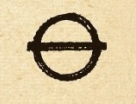

In [73]:
zeros = list(data_dir.glob('0/*'))
PIL.Image.open(str(zeros[0]))

And some nines:

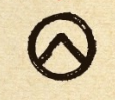

In [74]:
nines = list(data_dir.glob('9/*'))
PIL.Image.open(str(nines[0]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [75]:
img_height = 130
img_width = 100

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [76]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

Found 10 files belonging to 10 classes.
Using 8 files for training.


In [77]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [78]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

Found 10 files belonging to 10 classes.
Using 2 files for validation.


## Overfitting

In [79]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

typeof

In [80]:
type(data_augmentation)

tensorflow.python.keras.engine.sequential.Sequential

Visualize traind data with data_augmentation

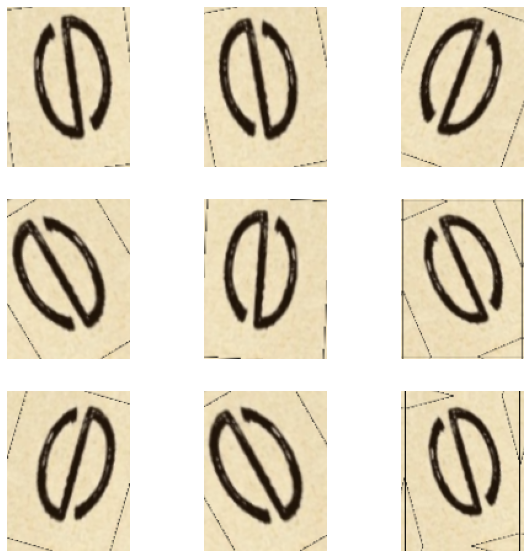

In [81]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Visualize validation images with data_augmentation

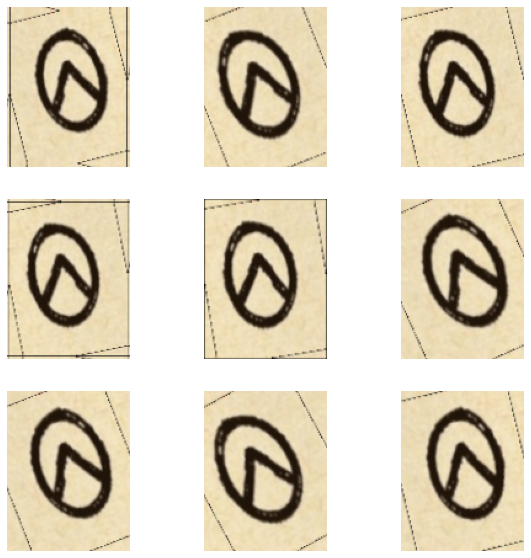

In [82]:
plt.figure(figsize=(10, 10))
for images, _ in val_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [83]:
class_names = train_ds.class_names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Visualize the data

Here are the first 5 images from the training dataset.

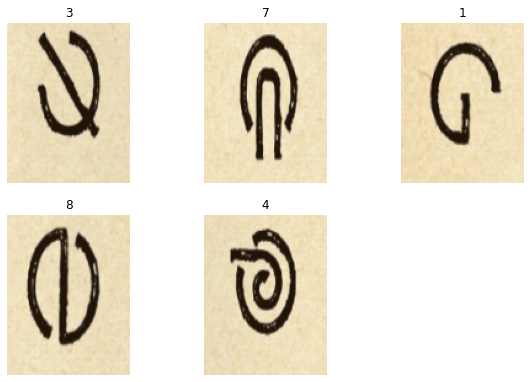

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [85]:
num_classes = 10

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [87]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 130, 100, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 130, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 130, 100, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 65, 50, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 65, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 25, 64)       

## Train the model

In [91]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
1/1 [==============================] - 0s 88ms/step - loss: 0.7722 - accuracy: 0.8750 - val_loss: 16.7274 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 80ms/step - loss: 0.6158 - accuracy: 1.0000 - val_loss: 17.7831 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 78ms/step - loss: 0.5958 - accuracy: 0.8750 - val_loss: 18.4686 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 85ms/step - loss: 1.0441 - accuracy: 0.6250 - val_loss: 19.7915 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 86ms/step - loss: 0.6935 - accuracy: 0.8750 - val_loss: 20.8802 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 79ms/step - loss: 0.4273 - accuracy: 1.0000 - val_loss: 21.9842 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 83ms/step - loss: 0.4208 - accuracy: 0.8750 - val_loss: 22.2201 - val_accuracy: 0.0

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

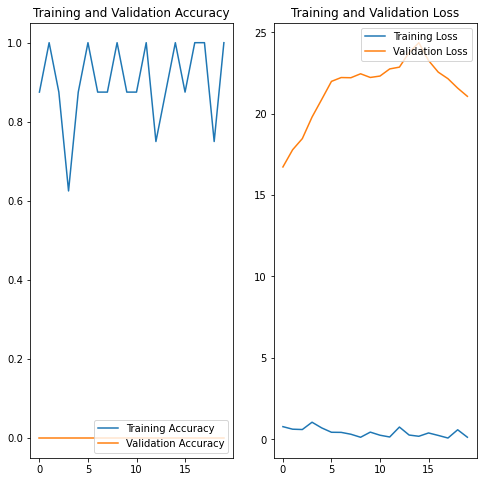

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [93]:
image_url = "https://raw.githubusercontent.com/alefcarlos/nazcaan-deep-learning/main/dataset/3/image.PNG"
predicte_image_path = tf.keras.utils.get_file('predictImage', origin=image_url)

print(predicte_image_path)

img = keras.preprocessing.image.load_img(
    predicte_image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

C:\Users\alefc\.keras\datasets\predictImage
This image most likely belongs to 3 with a 97.87 percent confidence.


End